In [2]:
import os
import warnings
import re
import random
import math
import pandas as pd
import numpy as np
import scipy
import sklearn
import configparser
import datetime

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pylab import rcParams

-----------------------------------------------------------------------------------------------------
-----------------------------  Data Creation  -------------------------------------------------------
-----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------

Connecting to the database:
-----------------------------------------------------------------------------------------------------

Reading Feeds Data
Feeds Data: (5113, 27)


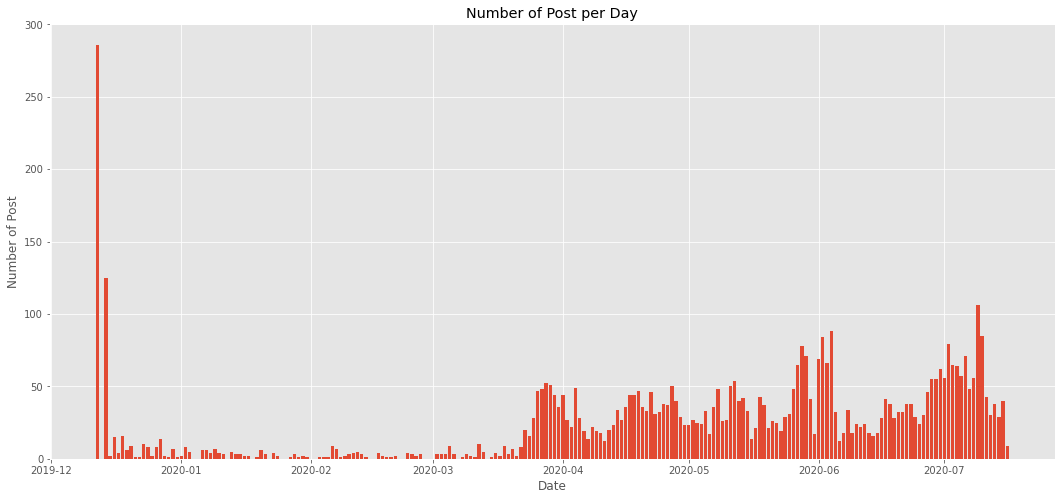

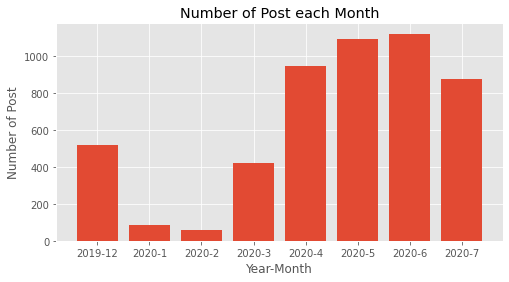

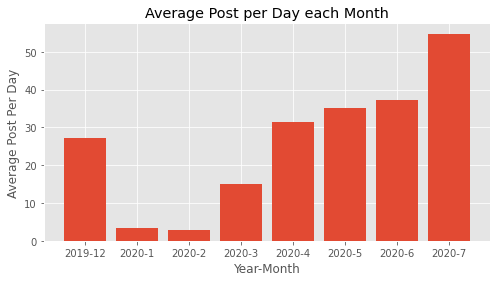

-----------------------------------------------------------------------------------------------------

 Procesing Likes Data:

Likes Summary:
Total Like Count: 16160
Total Content Like: 8788
Unique Content Like: 2776
Total Comment Like: 7372
Unique Comment Like: 5812
Average Likes on a Post:  3.1657060518731988


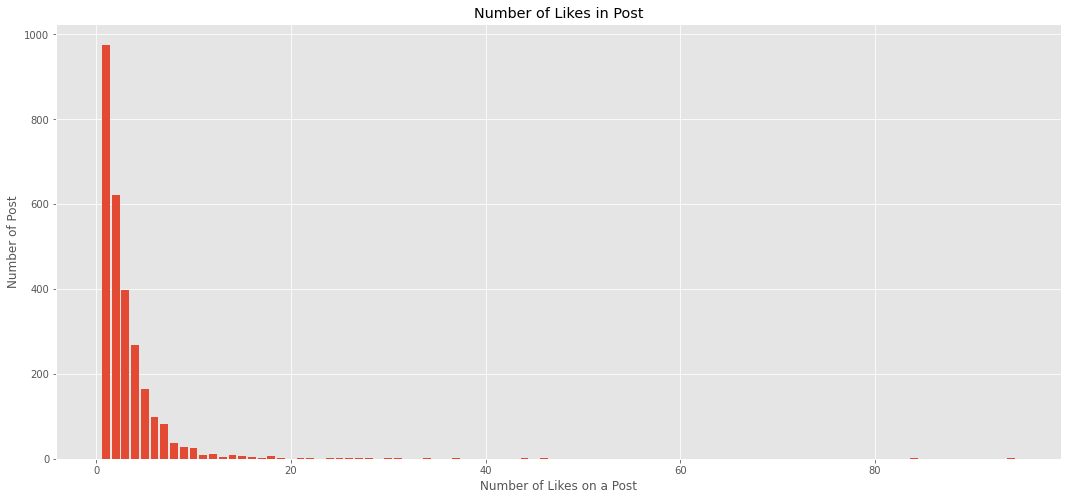

Average Likes on a Post:  3.1657060518731988


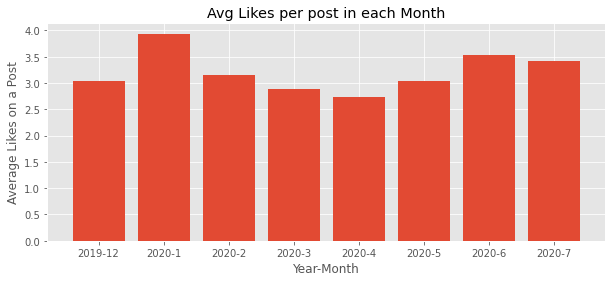

-----------------------------------------------------------------------------------------------------

Procesing Bookmarks Data

Bookmarks Summary:
Total bookmarks: 686
Unique Content with bookmark: 545
Unique Users with bookmark: 358
-----------------------------------------------------------------------------------------------------

Procesing Comments Data

Comments Summary:
Data Size: 16804
Total Comments: 16804
Total Post with comments: 4098
Total Primary Comments: 11723
Total SubComments: 5081
Average Comments on a Post:  4.100536847242557


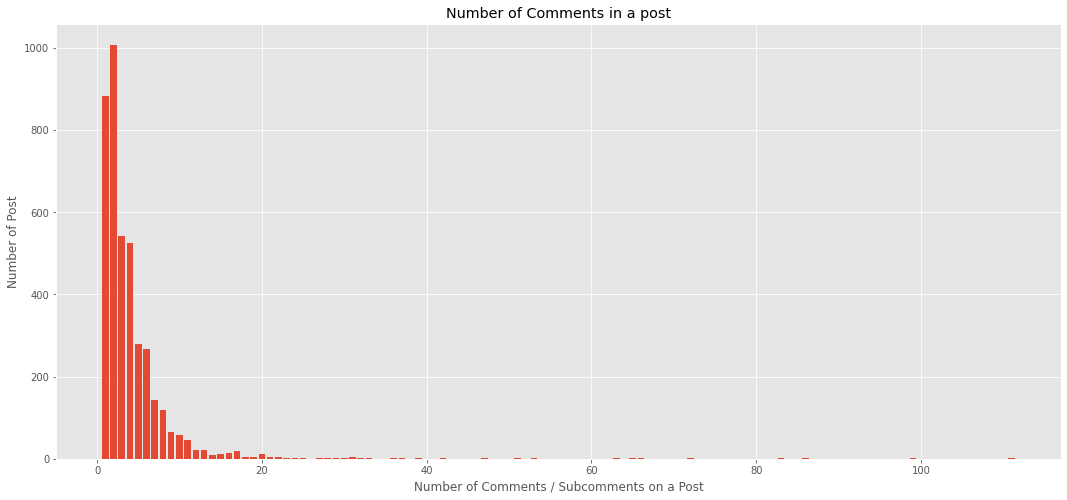

Average Comments on a Post:  4.100536847242557


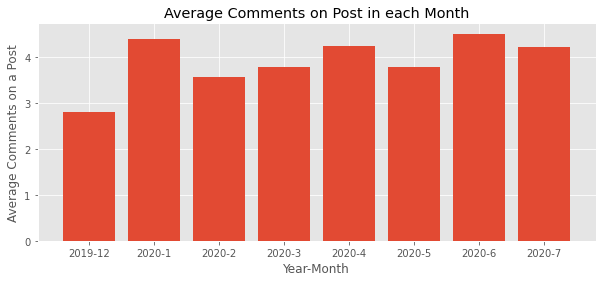

In [5]:
from Data_Creation_Pipeline_2 import *

# Configurations

In [6]:
config = configparser.ConfigParser()
config.read('reco_config.ini')
config.sections()

['Connection',
 'Data_Creation',
 'interaction_weight',
 'Evaluation',
 'recommendation',
 'modelling']

In [7]:
train_test_cutoff = config['Data_Creation']['train_test_date_cutoff']
recall_all_reco_count = int(config['Evaluation']['recall_all_reco_count'])
recency_cutoff = int(config['recommendation']['recency_cutoff'])
recency_cutoff_eval = int(config['recommendation']['recency_cutoff_eval'])

# Feed Data Input

In [8]:
#feeds_df = pd.read_csv(os.getcwd() + '/Datasets/feeds_df_for_reco.csv')
feeds_df = feeds_df[['contentId', 'anonymous', 'authorId', 'createdAt', 'isActive', 'isDelete', 'points', 'text', 'type', 'updatedAt', 'resource_videoUrl', 'resource_image']]
feeds_df['createdAt'] = pd.to_datetime(feeds_df['createdAt'])
feeds_df['updatedAt'] = pd.to_datetime(feeds_df['updatedAt'])
feeds_df = feeds_df[~feeds_df['text'].isna()]
#print(feeds_df.shape)
#feeds_df.head()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
#feeds_df.to_csv(os.getcwd() + '/Model_Output/feeds_df.csv', index = False)

# Interactions Data

In [11]:
print("-----------------------------------------------------------------------------------------------------")
print("\nCreating Interactions Data:")

-----------------------------------------------------------------------------------------------------

Creating Interactions Data:


In [12]:
likes_df = likes_coll_df.copy()
del likes_coll_df
likes_df = likes_df[likes_df['type'] != 'ARTICLE']
#print(likes_df.shape)
#likes_df.head(1)

In [13]:
bookmarks_df = bookmarks_coll_df.copy()
del bookmarks_coll_df
bookmarks_df = bookmarks_df[bookmarks_df['type'] != 'COMPANY']
#print(bookmarks_df.shape)
#bookmarks_df.head(1)

In [14]:
post_likes_df = likes_df[likes_df['type'] != 'COMMENT']
print("\nPost Likes:", post_likes_df.shape)
post_likes_df = post_likes_df[['likeId', 'referenceId', 'userId', 'createdAt', 'type']]
post_likes_df = post_likes_df.rename(columns = {'likeId':'eventId', 'referenceId':'contentId', 'userId':'personId'})
post_likes_df['eventType'] = 'LIKE'


Post Likes: (8727, 10)


In [15]:
likes_df_formatted = post_likes_df
#likes_df_formatted.head(1)

In [16]:
comments_df_formatted = comments_df[['commentId', 'referenceId', 'authorId', 'createdAt', 'type', 'isSubComment']]
comments_df_formatted = comments_df_formatted.rename(columns = {'commentId':'eventId', 'referenceId':'contentId', 'authorId':'personId'})
comments_df_formatted['eventType'] = np.where(comments_df_formatted['isSubComment'] == False, 'COMMENT', 'SUBCOMMENT')
comments_df_formatted = comments_df_formatted.drop(['isSubComment'], axis=1)
#comments_df_formatted.head(1)


In [17]:
bookmarks_df_formatted = bookmarks_df[['bookmarkId', 'referenceFeedId', 'userId', 'createdAt', 'type']]
bookmarks_df_formatted = bookmarks_df_formatted.rename(columns = {'bookmarkId':'eventId', 'referenceFeedId':'contentId', 'userId':'personId'})
bookmarks_df_formatted['eventType'] = 'BOOKMARK'
#bookmarks_df_formatted.head(1)

In [18]:
written_post_df_formatted = feeds_df[['contentId', 'authorId', 'createdAt', 'type']].copy()
written_post_df_formatted['eventId'] = written_post_df_formatted['contentId']
written_post_df_formatted = written_post_df_formatted.rename(columns = {'authorId':'personId'})
written_post_df_formatted = written_post_df_formatted[['eventId', 'contentId', 'personId', 'createdAt', 'type']]
written_post_df_formatted['eventType'] = 'CREATE POST'
#written_post_df_formatted.head(1)

In [19]:
interactions_df = likes_df_formatted.append([comments_df_formatted, bookmarks_df_formatted, written_post_df_formatted])
#print(interactions_df.shape)
#interactions_df.head(1)

In [20]:
#Removing content from interactions whih are not present in Feed data
interactions_df = interactions_df[interactions_df['contentId'].isin(feeds_df['contentId'])]
#print(interactions_df.shape)
#interactions_df.head(1)

In [21]:
#interaction_summary = interactions_df.groupby(['personId'])['contentId'].nunique().reset_index()
#interaction_summary.columns = ['personId', 'content_ct']
#interaction_summary = interaction_summary.sort_values(['content_ct'], ascending=False)
#print("Total Users:", interaction_summary.shape)
#print("Users with more than 1 content interaction:", interaction_summary[interaction_summary['content_ct']>1].shape)
#interaction_summary.head(1)


In [22]:
first_interaction = interactions_df.groupby(['personId', 'contentId'])['createdAt'].min().reset_index()
first_interaction['rank'] = first_interaction.groupby(['personId'])['createdAt'].rank(method="first", ascending = False)

content_count = first_interaction.groupby(['personId'])['contentId'].count().reset_index()
content_count.columns = ['personId', 'content_count']

first_interaction = pd.merge(first_interaction, content_count, how = 'left', on = ['personId'])

max_rank = first_interaction.groupby(['personId'])['rank'].max().reset_index()
max_rank.columns = ['personId', 'max_rank']

first_interaction = pd.merge(first_interaction, max_rank, how = 'left', on = ['personId'])
first_interaction['rank_proportion'] = (first_interaction['rank']/first_interaction['max_rank'])*100

first_interaction['interaction_category'] = np.where(first_interaction['content_count'] == 1, 'Single', 'Multi')

#first_interaction.head()

In [23]:
first_interaction_multi = first_interaction[first_interaction['interaction_category'] == 'Multi'].copy()

def custom_train_test_func(df):
    if( (df['content_count']<=4) & (df['rank']==1.0) ):
        return('Test')
    if( (df['content_count']>4) & (df['rank_proportion']<=20.00000) & (df['rank']<=10.0) ):
        return('Test')
    else:
        return('Train')

first_interaction_multi['train_test'] = first_interaction_multi.apply(custom_train_test_func, axis=1)
#first_interaction['train_test'] = np.where((first_interaction['interaction_category']=='Multi') & (first_interaction['rank_proportion']<=33.33333), "Test", "Train")
#first_interaction_multi.head(5)

In [24]:
print('Train', first_interaction_multi[first_interaction_multi['train_test']=='Train'].shape)
print('Test', first_interaction_multi[first_interaction_multi['train_test']=='Test'].shape)

Train (17038, 9)
Test (2899, 9)


In [25]:
print("-----------------------------------------------------------------------------------------------------")
print("------------------------------------  Model Development ---------------------------------------------")
print("-----------------------------------------------------------------------------------------------------")

-----------------------------------------------------------------------------------------------------
------------------------------------  Model Development ---------------------------------------------
-----------------------------------------------------------------------------------------------------


# Data Wrangling

In [26]:
print("-----------------------------------------------------------------------------------------------------")
print("Computing Event Strength")

-----------------------------------------------------------------------------------------------------
Computing Event Strength


In [27]:
event_type_strength = {
#   'VIEW': 1.0,
   'LIKE': float(config['interaction_weight']['like']), 
   'BOOKMARK': float(config['interaction_weight']['bookmark']), 
#   'FOLLOW': 3.0,
   'COMMENT': float(config['interaction_weight']['comment']),
    'SUBCOMMENT': float(config['interaction_weight']['subcomment']),
    'CREATE POST':float(config['interaction_weight']['create_post'])
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

In [28]:
print("-----------------------------------------------------------------------------------------------------")
print("Identifying users with single or multiple interactions")

-----------------------------------------------------------------------------------------------------
Identifying users with single or multiple interactions


In [29]:
users_interactions_count_df = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_1_interactions_df = users_interactions_count_df[users_interactions_count_df == 1].reset_index()[['personId']]
print('# users with 1 interactions: %d' % len(users_with_1_interactions_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 2].reset_index()[['personId']]
print('# users with at least 2 interactions: %d' % len(users_with_enough_interactions_df))

# users: 4611
# users with 1 interactions: 2770
# users with at least 2 interactions: 1841


In [30]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_multi_inter_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 2 interactions: %d' % len(interactions_from_multi_inter_users_df))

# of interactions: 31330
# of interactions from users with at least 2 interactions: 27330


In [31]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_single_inter_users_df = interactions_df.merge(users_with_1_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with 1 interaction: %d' % len(interactions_from_single_inter_users_df))

# of interactions: 31330
# of interactions from users with 1 interaction: 4000


In [32]:
#Smoothening the interaction scores
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_multi_df = interactions_from_multi_inter_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item multiple interactions: %d' % len(interactions_multi_df))
#interactions_multi_df.head()

# of unique user/item multiple interactions: 19937


In [33]:
#Smoothening Interactions Dataframe for users with single interaction
interactions_single_df = interactions_from_single_inter_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item single interactions: %d' % len(interactions_single_df))
#interactions_single_df.head()

# of unique user/item single interactions: 2770


In [34]:
#Append Multi and Single interaction users' dataset to a full interaction dataframe
full_interaction_df = interactions_multi_df.append(interactions_single_df)
#full_interaction_df.head()

In [35]:
user_interaction_category = users_interactions_count_df.reset_index()
user_interaction_category.columns = ['personId', 'interaction_count']
user_interaction_category.head()

user_interaction_count_summary = user_interaction_category.groupby(['interaction_count'])['personId'].count().reset_index()

#%matplotlib inline
#rcParams['figure.figsize'] = 15, 5
#plt.style.use('ggplot')
#plt.bar(user_interaction_count_summary['interaction_count'], user_interaction_count_summary['personId'])
#plt.xlabel("Interaction Count")
#plt.ylabel("Number of Person Id")
#plt.show()

In [36]:
print("-----------------------------------------------------------------------------------------------------")
print("Clustering Users based on number of interactions for model evaluation by cluster")

-----------------------------------------------------------------------------------------------------
Clustering Users based on number of interactions for model evaluation by cluster


In [37]:
#Clustering the users into buckets based on their interaction count
def interaction_category_func(df):
    if(df['interaction_count'] == 1):
        return("1")
    if(df['interaction_count'] == 2):
        return("2")
    if((df['interaction_count'] > 2) & (df['interaction_count'] <= 5)):
        return("3 to 5")
    if((df['interaction_count'] > 5) & (df['interaction_count'] <= 10)):
        return("6 to 10")
    if((df['interaction_count'] > 10) & (df['interaction_count'] <= 50)):
        return("11 to 50")
    if(df['interaction_count'] > 50):
        return("More than 50")
    else:
        return(np.nan)

def interaction_ordering_func(df):
    if(df['interaction_count'] == 1):
        return(1)
    if(df['interaction_count'] == 2):
        return(2)
    if((df['interaction_count'] > 2) & (df['interaction_count'] <= 5)):
        return(3)
    if((df['interaction_count'] > 5) & (df['interaction_count'] <= 10)):
        return(4)
    if((df['interaction_count'] > 10) & (df['interaction_count'] <= 50)):
        return(5)
    if(df['interaction_count'] > 50):
        return(6)
    else:
        return(np.nan)
    
user_interaction_category['interaction_category'] = user_interaction_category.apply(interaction_category_func, axis = 1)
user_interaction_category['order'] = user_interaction_category.apply(interaction_ordering_func, axis = 1)
user_interaction_category.groupby(['order', 'interaction_category'])['personId'].count().reset_index()

,order,interaction_category,personId
0,1,1,2770
1,2,2,771
2,3,3 to 5,611
3,4,6 to 10,233
4,5,11 to 50,164
5,6,More than 50,62


# Evaluation

In [38]:
print("-----------------------------------------------------------------------------------------------------")
print("Divide the data into Train Test Sample:")

-----------------------------------------------------------------------------------------------------
Divide the data into Train Test Sample:


In [39]:
## Time Bound Sampling

interactions_multi_df_time = pd.merge(interactions_multi_df, first_interaction_multi[['personId', 'contentId', 'train_test']], how = 'left', on = ['personId', 'contentId'])
interactions_multi_df_time.head()

interactions_multi_train_df = interactions_multi_df_time[interactions_multi_df_time['train_test'] == 'Train']
interactions_multi_train_df = interactions_multi_train_df.drop(['train_test'], axis=1)

interactions_multi_test_df = interactions_multi_df_time[interactions_multi_df_time['train_test'] == 'Test']
interactions_multi_test_df = interactions_multi_test_df.drop(['train_test'], axis=1)

print('# interactions on Multi Train set: %d' % len(interactions_multi_train_df))
print('# interactions on Multi Test set (These are old customers with History): %d' % len(interactions_multi_test_df))


interactions_single_df_time = pd.merge(interactions_single_df, first_interaction[['personId', 'contentId', 'createdAt']], how = 'left', on = ['personId', 'contentId'])
interactions_single_df_time = interactions_single_df_time.sort_values(['createdAt'])

#interactions_single_train_df = interactions_single_df_time[interactions_single_df_time['createdAt'] <= pd.to_datetime(train_test_cutoff)].copy()
interactions_single_train_df = interactions_single_df_time.head(round(interactions_single_df_time.shape[0]*0.8))
interactions_single_train_df = interactions_single_train_df.drop(['createdAt'], axis=1)

#interactions_single_test_df = interactions_single_df_time[interactions_single_df_time['createdAt'] > pd.to_datetime(train_test_cutoff)].copy()
interactions_single_test_df = interactions_single_df_time[~(interactions_single_df_time.personId.isin(interactions_single_train_df.personId))]
interactions_single_test_df = interactions_single_test_df.drop(['createdAt'], axis=1)

print('# interactions on Single Train set: %d' % len(interactions_single_train_df))
print('# interactions on Single Test set (These are new customers with no History): %d' % len(interactions_single_test_df))


# interactions on Multi Train set: 17038
# interactions on Multi Test set (These are old customers with History): 2899
# interactions on Single Train set: 2216
# interactions on Single Test set (These are new customers with no History): 554


In [40]:
## Random Sampling
# Take 20% random content as Test. 
# However perform stratified sampling on multi interaction user vs simple sampling for single interaction users

#interactions_multi_train_df, interactions_multi_test_df = train_test_split(interactions_multi_df,
#                                   stratify=interactions_multi_df['personId'], 
#                                   test_size=0.20,
#                                   random_state=42)

#print('# interactions on Multi Train set: %d' % len(interactions_multi_train_df))
#print('# interactions on Multi Test set (These are old customers with History): %d' % len(interactions_multi_test_df))

#interactions_single_train_df, interactions_single_test_df = train_test_split(interactions_single_df,
#                                   #stratify=interactions_multi_df['personId'], 
#                                   test_size=0.20,
#                                   random_state=42)

#print('# interactions on Single Train set: %d' % len(interactions_single_train_df))
#print('# interactions on Single Test set (These are new customers with no History): %d' % len(interactions_single_test_df))

In [41]:
#For standardisation of accuracy comparison across users limit the test case content to max 10 for each user
for_N_test_case = interactions_multi_test_df.copy()
for_N_test_case['rank'] = for_N_test_case.groupby(['personId'])['contentId'].apply(lambda x: x.rank())
for_N_test_case = for_N_test_case.sort_values(['personId', 'rank'], ascending = [True, True])

N_test_cases = for_N_test_case[for_N_test_case['rank']<=10].copy()
add_rest_to_train = for_N_test_case[for_N_test_case['rank']>10].copy()

N_test_cases = N_test_cases.drop(['rank'], axis=1)
add_rest_to_train = add_rest_to_train.drop(['rank'], axis=1)

print("N_test_cases: ", N_test_cases.shape)
print("add_rest_to_train: ", add_rest_to_train.shape)

N_test_cases:  (2899, 3)
add_rest_to_train:  (0, 3)


In [42]:
interactions_multi_train_df = interactions_multi_train_df.append(add_rest_to_train)
interactions_multi_test_df = N_test_cases

In [43]:
print('# interactions on Multi Train set: %d' % len(interactions_multi_train_df))
print('# interactions on Multi Test set (These are old customers with History): %d' % len(interactions_multi_test_df))

# interactions on Multi Train set: 17038
# interactions on Multi Test set (These are old customers with History): 2899


In [44]:
#Append the multi and single interaction users train and test dataframes to get single train and test dataframes
interactions_train_df = interactions_multi_train_df.append(interactions_single_train_df)
interactions_test_df = interactions_multi_test_df.append(interactions_single_test_df)

In [45]:
interactions_total_df = interactions_train_df.append(interactions_test_df)

In [46]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = full_interaction_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')
interactions_single_train_indexed_df = interactions_single_train_df.set_index('personId')
interactions_single_test_indexed_df = interactions_single_test_df.set_index('personId')
interactions_multi_train_indexed_df = interactions_multi_train_df.set_index('personId')

In [47]:
#Save the interactions train dataframe for getting the interacted content for each user for filtering out
interactions_train_indexed_df.to_csv(os.getcwd() + '/Model_Output/interactions_train_indexed_df.csv')

In [48]:
#Append the train and test indexed dataframe for getting the interacted count for each user during actual scoring 
interaction_total_indexed_df = interactions_train_indexed_df.append(interactions_test_indexed_df)
interaction_total_indexed_df.to_csv(os.getcwd() + '/Model_Output/interaction_total_indexed_df.csv')

In [49]:
#Count of random non interacted content to be sampled for evaluation during recall
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = int(config['Evaluation']['eval_random_sample_non_interacted_items'])

In [50]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    if(((pd.Series(person_id).isin(pd.Series(interactions_df.index.unique().to_list()))) == True)[0]):
        interacted_items = interactions_df.loc[person_id]['contentId']
        return(set(interacted_items if type(interacted_items) == pd.Series else [interacted_items]))
    else:
        interacted_items = set()
        return(interacted_items)
    

In [51]:
def get_not_interacted_items_sample(person_id, sample_size, seed=42):
    interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
    all_items = set(feeds_df['contentId'])
    non_interacted_items = all_items - interacted_items

    random.seed(seed)
    non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
    return set(non_interacted_items_sample)

In [52]:
def _verify_hit_top_n(item_id, recommended_items, topn):
    try:
        index = next(i for i, c in enumerate(recommended_items) if c == item_id)
    except:
        index = -1
    hit = int(index in range(0, topn))
    return hit, index

In [53]:
#Customisation
def evaluate_model_for_user(model, person_id):
    #Getting the items in test set
    interacted_values_testset = interactions_test_indexed_df.loc[person_id]
    if type(interacted_values_testset['contentId']) == pd.Series:
        person_interacted_items_testset = set(interacted_values_testset['contentId'])
    else:
        person_interacted_items_testset = set([interacted_values_testset['contentId']])  
    interacted_items_count_testset = len(person_interacted_items_testset) 
    
    #Getting a ranked recommendation list from a model for a given user
    person_recs_df = model.recommend_items(person_id, 
                                         items_to_ignore=get_items_interacted(person_id, 
                                         interactions_train_indexed_df), 
                                         topn=1000000000)
    person_recs_df['personId'] = person_id
    top_100_reco = person_recs_df[0:recall_all_reco_count]
    
    hits_at_5_count = 0
    hits_at_10_count = 0
    #For each item the user has interacted in test set
    for item_id in person_interacted_items_testset:
        #Getting a random sample (100) items the user has not interacted 
        #(to represent items that are assumed to be no relevant to the user)
        non_interacted_items_sample = get_not_interacted_items_sample(person_id, 
                                                      sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                      seed=int(re.sub(r'[a-zA-Z]', r'', item_id))%(2**32))

        #Combining the current interacted item with the 100 random items
        items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

        #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
        valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
        valid_recs = valid_recs_df['contentId'].values
        
        #Verifying if the current interacted item is among the Top-N recommended items
        hit_at_5, index_at_5 = _verify_hit_top_n(item_id, valid_recs, 5)
        hits_at_5_count += hit_at_5
        hit_at_10, index_at_10 = _verify_hit_top_n(item_id, valid_recs, 10)
        hits_at_10_count += hit_at_10
        

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
    hits_at_all_count = sum(pd.Series(list(person_interacted_items_testset)).isin(top_100_reco['contentId']))
    
    recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
    recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)
    recall_at_all = hits_at_all_count / float(interacted_items_count_testset)

    person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'hits@all_count':hits_at_all_count,
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10,
                          'recall@all': recall_at_all,
                          'model_name': model.get_model_name()}
    return person_metrics, person_recs_df[0:10]

In [54]:
#Customisation
def evaluate_model(model, pop_model):
    #print('Running evaluation for users')
    people_metrics = []
    reco_list = pd.DataFrame(columns = ['contentId', 'eventStrength', 'createdAt', 'time_since_post', 'recency_rank', 'personId'])
    zero_recos = 0
    for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
        #if idx % 100 == 0 and idx > 0:
        #    print('%d users processed' % idx)
        #print(person_id)
        if((pd.Series(person_id).isin(interactions_single_test_indexed_df.index)[0] == True) | (pd.Series(person_id).isin(interactions_multi_train_indexed_df.index)[0] == False)):
            person_metrics, rec_list = evaluate_model_for_user(pop_model, person_id)
        else:
            person_metrics, rec_list = evaluate_model_for_user(model, person_id)
        person_metrics['_person_id'] = person_id
        people_metrics.append(person_metrics)
        reco_list = reco_list.append(rec_list)
        
        if(rec_list.shape[0] == 0):
            zero_recos = zero_recos + 1
            
    print('%d users processed' % idx)
    print('%d person with zero recos' % zero_recos)

    detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
    global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
    global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
    global_recall_at_all = detailed_results_df['hits@all_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
    global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10,
                        'recall@all': global_recall_at_all}
    
    
    return global_metrics, detailed_results_df, reco_list

In [55]:
#last_interaction_in_train = pd.merge(interactions_train_df, first_interaction[['personId', 'contentId', 'createdAt']], how = 'left', on = ['personId', 'contentId'])
#last_interaction_in_train = last_interaction_in_train.rename(columns = {'createdAt':'last_interaction_dt'})
#last_interaction_in_train.head()


In [56]:
recency_df = feeds_df[['contentId', 'createdAt']].copy()
recency_df['time_since_post'] = recency_df['createdAt'].max() - recency_df['createdAt']
recency_df = recency_df.sort_values(['time_since_post'], ascending=True)
recency_df['recency_rank'] = list(range(recency_df.shape[0]))
#print(recency_df.shape)
#recency_df.head()

In [57]:
#def recency_of_recommendation_func(all_recommendations, person_id):
#    recommendation_with_recency = pd.merge(all_recommendations, recency_df[['contentId', 'createdAt', 'time_since_post', 'recency_rank']], how = 'left', on = 'contentId')
#        
#    if(pd.Series(person_id).isin(last_interaction_in_train['personId'])[0]):
#        max_date = last_interaction_in_train[last_interaction_in_train['personId'] == person_id]['last_interaction_dt'].max()
#        recommendation_with_recency = recommendation_with_recency[recommendation_with_recency['createdAt'] > max_date]
#    else:
#        recommendation_with_recency = recommendation_with_recency[recommendation_with_recency['recency_rank']<=800]
#    return(recommendation_with_recency)

In [58]:
#Recency function to retain the most recent recommendations
def recency_of_recommendation_func(all_recommendations, person_id):
    recommendation_with_recency = pd.merge(all_recommendations, recency_df[['contentId', 'createdAt', 'time_since_post', 'recency_rank']], how = 'left', on = 'contentId')
    recommendation_with_recency = recommendation_with_recency[recommendation_with_recency['recency_rank']<=recency_cutoff_eval]
    return(recommendation_with_recency)

# Popularity Model

In [59]:
print("-----------------------------------------------------------------------------------------------------")
print("----------------------------------------  Popularity Model ------------------------------------------")
print("Popularity Model Start: ", datetime.datetime.now())

-----------------------------------------------------------------------------------------------------
----------------------------------------  Popularity Model ------------------------------------------


In [60]:
#For popularity use the entire set consisting of single interaction data as well as multiple interaction
full_interaction_df = interactions_multi_df.append(interactions_single_df)

#Computes the most popular items
item_popularity_df = full_interaction_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
#item_popularity_df.head(10)

In [61]:
item_popularity_df.to_csv(os.getcwd() + '/Model_Output/item_popularity_df.csv', index = False)

In [62]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId']]
        
        #recommendations_df = recency_of_recommendation_func(recommendations_df, user_id)


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, feeds_df)

In [63]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [64]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df, full_reco_list = evaluate_model(popularity_model, popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head()

Evaluating Popularity recommendation model...
2394 users processed
0 person with zero recos

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.29510570518389806, 'recall@10': 0.3871995366348103, 'recall@all': 0.20735592238633072}


,hits@5_count,hits@10_count,hits@all_count,interacted_count,recall@5,recall@10,recall@all,model_name,_person_id
0,6,8,4,10,0.6,0.8,0.4,Popularity,5df38de0b2694d0016bdb71f
122,0,2,0,10,0.0,0.2,0.0,Popularity,5df73975d092c70016203c1f
363,5,8,1,10,0.5,0.8,0.1,Popularity,5e80c1970eed8d002a50bac6
36,3,3,2,10,0.3,0.3,0.2,Popularity,5df4627f7e4ea600161b900c
358,6,6,2,10,0.6,0.6,0.2,Popularity,5e809291b0854d0031972a19


In [65]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.005476237042831997


In [66]:
def summary_results_func(detailed_results_df, mod_global_metrics):
    detailed_results_df = pd.merge(detailed_results_df, user_interaction_category, how = 'left', left_on = '_person_id', right_on = 'personId')
    detailed_results_df = detailed_results_df.drop(['personId'], axis = 1)
    mod_summary = detailed_results_df.groupby(['order', 'interaction_category']).agg({'_person_id':'count', 'recall@10':'mean', 'recall@5':'mean', 'recall@all':'mean', 'interacted_count':'mean'}).reset_index()
    mod_summary = mod_summary.rename(columns = {'interacted_count':'interacted_in_test_avg'})
    
    overall_summary = pd.DataFrame(index = [0], columns=mod_summary.columns)
    overall_summary['order'] = mod_summary['order'].max()+1
    overall_summary['interaction_category'] = 'Total'
    overall_summary['_person_id'] = mod_summary['_person_id'].sum()
    overall_summary['recall@10'] = mod_global_metrics['recall@10']
    overall_summary['recall@5'] = mod_global_metrics['recall@5']
    overall_summary['recall@all'] = mod_global_metrics['recall@all']
    overall_summary['interacted_in_test_avg'] = sum(mod_summary['interacted_in_test_avg']*mod_summary['_person_id'])/sum(mod_summary['_person_id'])
    final_mod_summary = mod_summary.append(overall_summary)
    return(final_mod_summary)


In [67]:
pop_summary = summary_results_func(pop_detailed_results_df, pop_global_metrics)
pop_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,554,0.413357,0.342960,0.292419,1.000000
1,2,2,771,0.354086,0.278859,0.203632,1.000000
2,3,3 to 5,611,0.422259,0.324059,0.232406,1.000000
3,4,6 to 10,233,0.442060,0.311159,0.190987,1.098712
4,5,11 to 50,164,0.367581,0.293089,0.195833,3.908537
5,6,More than 50,62,0.383871,0.256452,0.140323,10.000000
0,7,Total,2395,0.387200,0.295106,0.207356,1.441754


In [ ]:
print("Popularity Model End: ", datetime.datetime.now())

# Content-Based Filtering model

In [68]:
print("-----------------------------------------------------------------------------------------------------")
print("-------------------------------------  Content Based Model ------------------------------------------")

-----------------------------------------------------------------------------------------------------
-------------------------------------  Content Based Model ------------------------------------------


In [69]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = feeds_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(feeds_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
#tfidf_matrix

In [70]:
import pickle
f = open(os.getcwd() + '/Model_Output/tfidf_matrix.pkl',"wb")
pickle.dump(tfidf_matrix,f)
f.close()

#with open(os.getcwd() + '/Model_Output/tfidf_matrix.pkl', 'rb') as f:
#    tfidf_matrix = pickle.load(f)


In [71]:
def get_item_profile(item_id):
    #print(item_id)
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    #print(ids)
    if(isinstance(ids, str)):
        ids = [ids]
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    #print(person_id)
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['contentId'] \
                                                   .isin(feeds_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        #print(person_id)
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [72]:
user_profiles = build_users_profiles()
#len(user_profiles)

In [73]:
import pickle
#f = open(os.getcwd() + '/Model_Output/user_profiles.pkl',"wb")
#pickle.dump(user_profiles,f)
#f.close()

In [74]:
#with open(os.getcwd() + '/Model_Output/user_profiles.pkl', 'rb') as f:
#    user_profiles = pickle.load(f)


In [75]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId']]
        
        recommendations_df = recency_of_recommendation_func(recommendations_df, user_id)
        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(feeds_df)

In [76]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [77]:
#print('Evaluating Content-Based Filtering model...')
#cb_global_metrics, cb_detailed_results_df, full_reco_list = evaluate_model(content_based_recommender_model, popularity_model)
#print('\nGlobal metrics:\n%s' % cb_global_metrics)
#cb_detailed_results_df.head(10)

In [78]:
#temp = cb_detailed_results_df[cb_detailed_results_df['model_name'] != 'Popularity']
#print("Content Based Model: ", temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

#temp = cb_detailed_results_df[cb_detailed_results_df['model_name'] == 'Popularity']
#print("Popularity Model: ", temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

In [79]:
#cb_summary = summary_results_func(cb_detailed_results_df, cb_global_metrics)
#cb_summary

In [80]:
#print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

### Creating all user profiles for scoring and not just the train set 

In [81]:
def build_users_profiles_all(): 
    interactions_indexed_df = interactions_total_df[interactions_total_df['contentId'] \
                                                   .isin(feeds_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        #print(person_id)
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [82]:
user_profiles_all = build_users_profiles_all()
#len(user_profiles_all)

In [83]:
import pickle
#f = open(os.getcwd() + '/Model_Output/user_profiles_all.pkl',"wb")
#pickle.dump(user_profiles_all,f)
#f.close()

# Collaborative Filtering model

### Matrix Factorization

In [84]:
print("-----------------------------------------------------------------------------------------------------")
print("-------------------------------  SVD based Collaborative Filtering Model ----------------------------")

-----------------------------------------------------------------------------------------------------
-------------------------------  SVD based Collaborative Filtering Model ----------------------------


In [85]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

#users_items_pivot_matrix_df.head(10)

In [86]:
#users_items_pivot_matrix_df.shape

In [87]:
#users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix = users_items_pivot_matrix_df.to_numpy()
#users_items_pivot_matrix[:10]

In [88]:
users_ids = list(users_items_pivot_matrix_df.index)
#users_ids[:10]

In [89]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
#users_items_pivot_sparse_matrix

In [90]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 20
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)
print("U", U.shape)
print("Vt", Vt.shape)
sigma = np.diag(sigma)
print("sigma", sigma.shape)

U (4057, 20)
Vt (20, 5006)
sigma (20, 20)


In [91]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
#print(all_user_predicted_ratings.shape)
#all_user_predicted_ratings
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [92]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
#cf_preds_df.head(10)

In [94]:
import pickle
#f = open(os.getcwd() + '/Model_Output/cf_preds_df.pkl',"wb")
#pickle.dump(cf_preds_df,f)
#f.close()

#with open(os.getcwd() + '/Model_Output/cf_preds_df.pkl', 'rb') as f:
#    cf_preds_df = pickle.load(f)


In [95]:
#len(cf_preds_df.columns)

In [96]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId']]

        recommendations_df = recency_of_recommendation_func(recommendations_df, user_id)
        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, feeds_df)

In [97]:
#print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
#cf_global_metrics, cf_detailed_results_df, full_reco_list = evaluate_model(cf_recommender_model, popularity_model)
#print('\nGlobal metrics:\n%s' % cf_global_metrics)
#cf_detailed_results_df.head(10)

In [98]:
#temp = cf_detailed_results_df[cf_detailed_results_df['model_name'] != 'Popularity']
#print("Collaborative Filtering: ", temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

#temp = cf_detailed_results_df[cf_detailed_results_df['model_name'] == 'Popularity']
#print("Popularity Model: ", temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")


In [99]:
#cf_summary = summary_results_func(cf_detailed_results_df, cf_global_metrics)
#cf_summary

In [100]:
#print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

### Fitting model on all data to capture all user-item interactions for scoring and not just the train set 

In [102]:
### Fitting Model on entire data


#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df_all = interactions_total_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df_all.head(10)

#users_items_pivot_matrix_all = users_items_pivot_matrix_df_all.as_matrix()
users_items_pivot_matrix_all = users_items_pivot_matrix_df_all.to_numpy()

users_ids_all = list(users_items_pivot_matrix_df_all.index)

users_items_pivot_sparse_matrix_all = csr_matrix(users_items_pivot_matrix_all)

#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 20
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U_all, sigma_all, Vt_all = svds(users_items_pivot_sparse_matrix_all, k = NUMBER_OF_FACTORS_MF)
print("U_all", U_all.shape)
print("Vt_all", Vt_all.shape)
sigma_all = np.diag(sigma_all)
print("sigma_all", sigma_all.shape)

all_user_predicted_ratings_all = np.dot(np.dot(U_all, sigma_all), Vt_all) 
print(all_user_predicted_ratings_all.shape)
#all_user_predicted_ratings
all_user_predicted_ratings_norm_all = (all_user_predicted_ratings_all - all_user_predicted_ratings_all.min()) / (all_user_predicted_ratings_all.max() - all_user_predicted_ratings_all.min())

#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df_all = pd.DataFrame(all_user_predicted_ratings_norm_all, columns = users_items_pivot_matrix_df_all.columns, index=users_ids_all).transpose()
#cf_preds_df_all.head(10)


U_all (4611, 20)
Vt_all (20, 5113)
sigma_all (20, 20)
(4611, 5113)


In [103]:
import pickle
#f = open(os.getcwd() + '/Model_Output/cf_preds_df_all.pkl',"wb")
#pickle.dump(cf_preds_df_all,f)
#f.close()

### User to User Collaborative Filtering 

In [104]:
print("-----------------------------------------------------------------------------------------------------")
print("--------------------------  User to User Collaborative Filtering Model ------------------------------")

-----------------------------------------------------------------------------------------------------
--------------------------  User to User Collaborative Filtering Model ------------------------------


In [105]:
user_factor_DF = pd.DataFrame(U)
user_factor_DF.index = users_items_pivot_matrix_df.index
user_factor_DF.columns = ['F'+ str(c) for c in list(range(1,user_factor_DF.shape[1]+1))]
#user_factor_DF.head()

In [106]:
user_factor_DF_PID = user_factor_DF.copy()
user_factor_DF_PID['personId'] = user_factor_DF_PID.index
user_factor_DF_PID.index = range(user_factor_DF.shape[0])
#user_factor_DF_PID.head()

In [107]:
class UsertoUserCFRecommender:
    
    MODEL_NAME = 'User-to-User'
    
    def __init__(self, items_df = None):
        self.items_df = items_df
        #self.user_factor_DF = user_factor_DF
        #self.user_factor_DF_PID = user_factor_DF_PID
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_items_by_similar_users(self, person_id, topn=100):
        #Computes the cosine similarity between the users to find similary users
        cosine_similarities = cosine_similarity(np.array(user_factor_DF[user_factor_DF.index==person_id]).reshape(1,-1), np.array(user_factor_DF))
        #Gets the top similar users
        similar_indices = cosine_similarities.argsort().flatten()[-1000:]
        matched_users = user_factor_DF_PID[user_factor_DF_PID.index.isin(pd.Series(similar_indices))]
        matched_users = matched_users[matched_users['personId'] != person_id]
        
        #Sort the similar items by similarity
        top_content = full_interaction_df[full_interaction_df['personId'].isin(matched_users['personId'])]
        top_content = top_content[['contentId', 'eventStrength']].groupby(['contentId'])['eventStrength'].sum().reset_index()
        top_content = top_content.sort_values(['eventStrength'], ascending=False)

        similar_items = top_content.head(topn)
        return similar_items
           
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_items_by_similar_users(user_id)
        # Recommend the items interacted by similar users
        recommendations_df = similar_items[~similar_items['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId']]
        
        recommendations_df = recency_of_recommendation_func(recommendations_df, user_id)
        return recommendations_df
u2u_cf_recommender_model = UsertoUserCFRecommender(feeds_df)

In [108]:
#print('Evaluating User to User Collaborative Filtering.....')
#ucf_global_metrics, ucf_detailed_results_df, full_reco_list = evaluate_model(u2u_cf_recommender_model, popularity_model)
#print('\nGlobal metrics:\n%s' % ucf_global_metrics)
#ucf_detailed_results_df.head(10)

In [109]:
#temp = ucf_detailed_results_df[ucf_detailed_results_df['model_name'] != 'Popularity']
#print("User to User: ", temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")
#
#temp = ucf_detailed_results_df[ucf_detailed_results_df['model_name'] == 'Popularity']
#print("Popularity Model: ", temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

In [110]:
#ucf_summary = summary_results_func(ucf_detailed_results_df, ucf_global_metrics)
#ucf_summary

In [111]:
#print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

### Hybrid Recommendation 

In [112]:
print("-----------------------------------------------------------------------------------------------------")
print("-------------------------------------------  Hybrid Model -------------------------------------------")
print("Hybrid Model Start: ", datetime.datetime.now())

-----------------------------------------------------------------------------------------------------
-------------------------------------------  Hybrid Model -------------------------------------------


In [113]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        cb_recs_df = cb_recs_df.drop(['createdAt', 'time_since_post', 'recency_rank'], axis=1)
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        cf_recs_df = cf_recs_df.drop(['createdAt', 'time_since_post', 'recency_rank'], axis=1)
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'outer', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) \
                                     + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId']]

        recommendations_df = recency_of_recommendation_func(recommendations_df, user_id)
        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, feeds_df,
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=50.0)


In [114]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df, full_reco_list = evaluate_model(hybrid_recommender_model, popularity_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
2394 users processed
0 person with zero recos

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.1789748045178106, 'recall@10': 0.228786562409499, 'recall@all': 0.12829423689545322}


,hits@5_count,hits@10_count,hits@all_count,interacted_count,recall@5,recall@10,recall@all,model_name,_person_id
0,3,3,2,10,0.3,0.3,0.2,Hybrid,5df38de0b2694d0016bdb71f
122,3,4,0,10,0.3,0.4,0.0,Hybrid,5df73975d092c70016203c1f
363,9,9,6,10,0.9,0.9,0.6,Hybrid,5e80c1970eed8d002a50bac6
36,0,0,0,10,0.0,0.0,0.0,Hybrid,5df4627f7e4ea600161b900c
358,6,8,3,10,0.6,0.8,0.3,Hybrid,5e809291b0854d0031972a19
309,8,8,2,10,0.8,0.8,0.2,Hybrid,5e7eec2f8735d5002991de35
291,0,0,0,10,0.0,0.0,0.0,Hybrid,5e7dde388735d5002991dbbb
274,0,0,0,10,0.0,0.0,0.0,Hybrid,5e7d8ae72b1c620022131ee5
246,0,0,0,10,0.0,0.0,0.0,Hybrid,5e7c79d8ad47950024ffd1db
245,2,2,1,10,0.2,0.2,0.1,Hybrid,5e7c74cc5e7b37002254c151


In [115]:
temp = hybrid_detailed_results_df[hybrid_detailed_results_df['model_name'] != 'Popularity']
print("Hybrid Model: ", temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

temp = hybrid_detailed_results_df[hybrid_detailed_results_df['model_name'] == 'Popularity']
print("Popularity Model: ", temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")


Hybrid Model:  0.193515005174198 for  1841  Users
Popularity Model:  0.41335740072202165 for  554  Users


In [116]:
hybrid_summary = summary_results_func(hybrid_detailed_results_df, hybrid_global_metrics)
hybrid_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,554,0.413357,0.342960,0.292419,1.000000
1,2,2,771,0.146563,0.102464,0.066148,1.000000
2,3,3 to 5,611,0.145663,0.098200,0.063830,1.000000
3,4,6 to 10,233,0.163090,0.128755,0.090129,1.098712
4,5,11 to 50,164,0.224961,0.172101,0.122435,3.908537
5,6,More than 50,62,0.282258,0.237097,0.141935,10.000000
0,7,Total,2395,0.228787,0.178975,0.128294,1.441754


In [117]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.14218658321924507


In [ ]:
print("Hybrid Model End: ", datetime.datetime.now())

# Comparing Methods

In [118]:
global_metrics_df = pd.DataFrame([pop_global_metrics
#                                  ,cb_global_metrics, 
#                                  ,cf_global_metrics, 
                                  ,hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10,recall@all
modelName,,,
Popularity,0.295106,0.387200,0.207356
Hybrid,0.178975,0.228787,0.128294


In [120]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title("Model Comparison")

plt.savefig(os.getcwd()+'/Charts/Model_Comparison.png')
plt.close()

In [121]:
pop_summary['model'] = 'popularity'
#cb_summary['model'] = 'content based'
#ucf_summary['model'] = 'user to user'
#cf_summary['model'] = 'collaborative filtering'
hybrid_summary['model'] = 'hybrid'

total_summary = pop_summary.append([
 #   cb_summary, 
 #   cf_summary, 
    hybrid_summary])
print(total_summary)

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg,model
0,1,1,554,0.413357,0.342960,0.292419,1.000000,popularity
1,2,2,771,0.354086,0.278859,0.203632,1.000000,popularity
2,3,3 to 5,611,0.422259,0.324059,0.232406,1.000000,popularity
3,4,6 to 10,233,0.442060,0.311159,0.190987,1.098712,popularity
4,5,11 to 50,164,0.367581,0.293089,0.195833,3.908537,popularity
5,6,More than 50,62,0.383871,0.256452,0.140323,10.000000,popularity
0,7,Total,2395,0.387200,0.295106,0.207356,1.441754,popularity
0,1,1,554,0.413357,0.342960,0.292419,1.000000,hybrid
1,2,2,771,0.146563,0.102464,0.066148,1.000000,hybrid
2,3,3 to 5,611,0.145663,0.098200,0.063830,1.000000,hybrid


In [122]:
tot = total_summary.pivot_table(index = ['order', 'interaction_category'], columns = 'model', values = 'recall@10')
tot.index = tot.index.get_level_values(1)
tot

model,hybrid,popularity
interaction_category,,
1,0.413357,0.413357
2,0.146563,0.354086
3 to 5,0.145663,0.422259
6 to 10,0.163090,0.442060
11 to 50,0.224961,0.367581
More than 50,0.282258,0.383871
Total,0.228787,0.387200


In [123]:
%matplotlib inline
ax = tot.plot(kind='bar', figsize=(15,8))
ax.title.set_text('Recall@10')
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title("Model Comparison by cluster - Recall@10")

plt.savefig(os.getcwd()+'/Charts/Model_Comparison_by_Cluster_Recall10.png')
plt.close()

In [124]:
tot = total_summary.pivot_table(index = ['order', 'interaction_category'], columns = 'model', values = 'recall@all')
tot.index = tot.index.get_level_values(1)
tot

model,hybrid,popularity
interaction_category,,
1,0.292419,0.292419
2,0.066148,0.203632
3 to 5,0.063830,0.232406
6 to 10,0.090129,0.190987
11 to 50,0.122435,0.195833
More than 50,0.141935,0.140323
Total,0.128294,0.207356


In [125]:
%matplotlib inline
ax = tot.plot(kind='bar', figsize=(15,8))
ax.title.set_text('Recall@all')
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
 

plt.title("Model Comparison by cluster - Recall@all")

plt.savefig(os.getcwd()+'/Charts/Model_Comparison_by_Cluster_Recall_all.png')
plt.close()